In [1]:
%pylab nbagg
%load_ext autoreload
%autoreload 2
%load_ext memory_profiler

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastcat.fastcat as fc
from glob import glob

## First I'll look at the detector MTF

### I'll load all of the kernels 

In [3]:
import os
from scipy.signal import fftconvolve, find_peaks, butter,filtfilt
from scipy.optimize import minimize, curve_fit
import tigre

mu_en_water = np.array([4.944, 0.5503, 0.1557  , 0.06947 , 0.04223 , 0.0319  , 0.027678, 0.02597 ,
    0.025434, 0.02546 , 0.03192 , 0.03299 , 0.032501, 0.031562,
    0.03103 , 0.02608 , 0.02066 , 0.01806 ])
mu_water = np.array([5.329, 0.8096, 0.3756  , 0.2683  , 0.2269  , 0.2059  , 0.19289 , 0.1837  ,
    0.176564, 0.1707  , 0.1186  , 0.09687 , 0.083614, 0.074411,
    0.07072 , 0.04942 , 0.03403 , 0.0277  ])

data_path = '../fastcat/data/'

class Phantom2:

    def __init__(self):
        pass

    def return_projs(self,kernel,spectra,angles,nphoton = None,
                    mgy = 0.,return_dose=False,det_on=True,scat_on=True,tigre_works = True):
        '''
        The main function for returning the projections
        '''
        
        self.tigre_works = tigre_works
        self.angles = angles
        
        # ----------------------------------------------------------
        # --- Making the weights for the different energies --------
        # ----------------------------------------------------------
        
        # These are what I used in the Monte Carlo
        deposition = np.load(kernel.deposition_efficiency_file,allow_pickle=True)
        
        # csi has two extra kv energies
        if len(deposition[0]) == 18:
            original_energies_keV = np.array([10,20,30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
            mu_en_water2 = mu_en_water
            mu_water2 = mu_water
        else:
            original_energies_keV = np.array([30, 40, 50 ,60, 70, 80 ,90 ,100 ,300 ,500 ,700, 900, 1000 ,2000 ,4000 ,6000])
            mu_en_water2 = mu_en_water[2:]
            mu_water2 = mu_water[2:]
            
        # Loading the file from the monte carlo
        # This is a scaling factor that I found to work to convert energy deposition to photon probability eta
        deposition_summed = deposition[0]/(original_energies_keV/1000)/1000000
        
        # Binning to get the fluence per energy
        large_energies = np.linspace(0,6000,3001)
        fluence_large = np.interp(large_energies,np.array(spectra.x), spectra.y)
        fluence_small = np.zeros(len(original_energies_keV))
        # Still binning
        for ii, val in enumerate(large_energies):   
            index = np.argmin(np.abs(original_energies_keV-val))
            fluence_small[index] += fluence_large[ii]       
        # Normalize
        fluence_small /= np.sum(fluence_small)
        fluence_norm = spectra.y/np.sum(spectra.y)

        #Changed the meaning of det on to be more det convolved
        weights_small = fluence_small*deposition_summed
        
        # Need to make sure that the attenuations aren't janky for recon
        weights_small /= np.sum(weights_small)
        
        # ----------------------------------------------
        # -------- Scatter Correction ------------------
        # ----------------------------------------------
        
        scatter = np.load(os.path.join(data_path,'scatter','scatter_updated.npy'))

        dist = np.linspace(-256*0.0784 - 0.0392,256*0.0784 - 0.0392, 512)

        def func(x, a, b):
            return ((-(152/(np.sqrt(x**2 + 152**2)))**a)*b)

        mc_scatter = np.zeros(scatter.shape)

        for jj in range(scatter.shape[1]):

            popt, popc = curve_fit(func,dist,scatter[:,jj],[10,scatter[256,jj]])
            mc_scatter[:,jj] = func(dist, *popt)

        if len(original_energies_keV) == 16:
            mc_scatter = mc_scatter[:,2:]

        factor = (152/(np.sqrt(dist**2 + 152**2)))**3
        flood_summed = factor*660 
        
        # ----------------------------------------------
        # -------- Ray Tracing -------------------------
        # ----------------------------------------------
        
        tile = True
        final_projection = np.zeros([len(angles),self.geomet.nDetector[0],self.geomet.nDetector[1]])

        # The index of the different materials
        masks = np.zeros([len(self.phan_map)-1,self.phantom.shape[0],self.phantom.shape[1],self.phantom.shape[2]])
        mapping_functions = []

        # Get the mapping functions for the different tissues to reconstruct the phantom by energy
        for ii in range(1,len(self.phan_map)):       
            mapping_functions.append(fc.get_mu(self.phan_map[ii].split(':')[0]))
            masks[ii-1] = self.phantom == ii
        
        phantom2 = self.phantom.copy().astype(np.float32)
        doses = []
        
        for jj, energy in enumerate(original_energies_keV):
            # Change the phantom values
            for ii in range(0,len(self.phan_map)-1):
                phantom2[masks[ii].astype(bool)] = mapping_functions[ii](energy)

            projection = self.ray_trace(phantom2,tile)
            kernel.kernels[jj+1] /= np.sum(kernel.kernels[jj+1])

            if det_on:
                for ii in range(len(self.angles)):
                    projection[ii,:,:] = fftconvolve(projection[ii,:,:],kernel.kernels[jj+1], mode = 'same')

            # Calculate a dose contribution by dividing by 10 since tigre has projections that are a little odd
            doses.append(np.mean((energy)*(1-np.exp(-(projection*.997)/10))*mu_en_water2[jj]/mu_water2[jj]))
            final_projection += projection*weights_small[jj]

        intensity = (np.exp(-0.97*np.array(final_projection)/10)*(flood_summed)).T # 0.97 is fudge factor

        # Add the already weighted scatter
        if scat_on:
            intensity = intensity.transpose([2,1,0]) + mc_scatter@weights_small
        else:
            intensity = intensity.transpose([2,1,0])
        
        # ----------------------------------------------
        # ----------- Dose calculation -----------------
        # ----------------------------------------------
        
        # Sum over the image dimesions to get the energy intensity and multiply by fluence TODO: what is this number?
        def get_dose_nphoton(nphot):
            return nphot/2e7

        def get_dose_mgy(mgy,doses,fluence_small):
            nphoton = mgy/(get_dose_per_photon(doses,fluence_small)*(1.6021766e-13))
            return get_dose_nphoton(nphoton)

        def get_dose_per_photon(doses,fluence_small):
            # linear fit of the data
            pp = np.array([0.88759883, 0.01035186])
            return ((doses/1000)@(fluence_small))*pp[0] + pp[1]

        ratio = None

        # Dose in micro grays
        if mgy != 0.0:
            ratio = get_dose_mgy(mgy,self.raw_doses,fluence_small)
        elif nphoton is not None:
            ratio = get_dose_nphoton(nphoton)
        
        # --- Noise and Scatter Calculation ---
        # Now I interpolate deposition and get the average photons reaching the detector
        deposition_long = np.interp(spectra.x,original_energies_keV/1000,deposition_summed)
        nphotons_at_energy = fluence_norm*deposition_long
        nphotons_av = np.sum(nphotons_at_energy)

        print('ratio is', ratio,'number of photons', nphotons_av)

        # ----------------------------------------------
        # ----------- Add Noise ------------------------
        # ----------------------------------------------

        if ratio is not None:
            
            if det_on:
                adjusted_ratio = ratio*nphotons_av
            else:
                adjusted_ratio = ratio
            
            intensity = np.random.poisson(lam=intensity*adjusted_ratio)/adjusted_ratio
            

        self.proj = -10*np.log(intensity/(flood_summed))
        
    def ray_trace(self,phantom2,tile):

        if self.tigre_works: # resort to astra if tigre doesn't work
            try:
                return np.squeeze(tigre.Ax(phantom2,self.geomet,self.angles))
            except Exception:
                print("WARNING: Tigre GPU not working. Switching to Astra CPU")

                sinogram, self.sin_id, self.proj_id, self.vol_geom = tigre2astra(phantom2,self.geomet,self.angles,tile=True)
                self.tigre_works = False
                return sinogram.transpose([1,0,2])
        else:
            if tile:
                sin_id, sinogram = astra.create_sino(np.fliplr(phantom2[0,:,:]), self.proj_id)

                return np.tile(sinogram,[phantom2.shape[0],1,1]).transpose([1,0,2])/(1.6*(self.geomet.nDetector[1]/256))
            else:
                sinogram = np.zeros([phantom2.shape[0],len(angles),self.geomet.nDetector[1]])

                sin_id = None

                ##??
                for kk in range(tigre_shape[0]):

                    if sin_id is not None:
                        astra.data2d.delete(sin_id)

                    sin_id, sinogram[kk,:,:] = astra.create_sino(np.fliplr(phantom2[kk,:,:]), self.proj_id)

                astra.data2d.delete(sin_id)

                return sinogram.transpose([1,0,2])/(1.6*(self.geomet.nDetector[1]/256))
        
class XCAT2(Phantom2):

    def __init__(self):
        self.phantom = np.load(os.path.join(data_path,'phantoms/ct_scan_smaller.npy'))
        self.geomet = tigre.geometry_default(high_quality=False,nVoxel=self.phantom.shape)
        self.geomet.nDetector = np.array([512,512])
        self.geomet.dDetector = np.array([0.784, 0.784])
        self.phan_map = ['air','air','lung','adipose','water','RED_MARROW_ICRP','INTESTINE_ICRP','PANCREAS_ICRP','G4_MUSCLE_SKELETAL_ICRP','KIDNEY_ICRP',
                         'HEART_ICRP','THYROID_ICRP','LIVER_ICRP','blood','SPLEEN_ICRP',
                        'CARTILAGE_ICRP','C4_Vertebra_ICRP','SKULL_ICRP',
                         'RIB_BONE_ICRP']

        self.geomet.DSD = 1500
        # I think I can get away with this
        self.geomet.sDetector = self.geomet.dDetector * self.geomet.nDetector    

        self.geomet.sVoxel = np.array((160, 160, 160)) 
        self.geomet.dVoxel = self.geomet.sVoxel/self.geomet.nVoxel 

    def analyse_515(self,slc,place,fmt='-'):

        pass
    
    def reconstruct(self,algo,filt='hamming'):
        
        if algo == 'FDK':
            try:
                self.img = tigre.algorithms.FDK(self.proj, self.geomet, self.angles,filter=filt)
            except Exception:
                print('WARNING: Tigre failed during recon using Astra')
                self.img = self.astra_recon(self.proj.transpose([1,0,2]))

In [4]:
spectra = glob('../fastcat/data/MV_spectra/*.txt')
phantoms = ['XCAT','XCAT2','Catphan_515','Catphan_MTF']
MV_detectors = glob('../fastcat/data/Detectors/*')

dispatcher={'Catphan_515':fc.Catphan_515,
            'XCAT':XCAT2,
            'XCAT2':fc.XCAT,
            'Catphan_MTF':fc.Catphan_MTF}

<IPython.core.display.Javascript object>


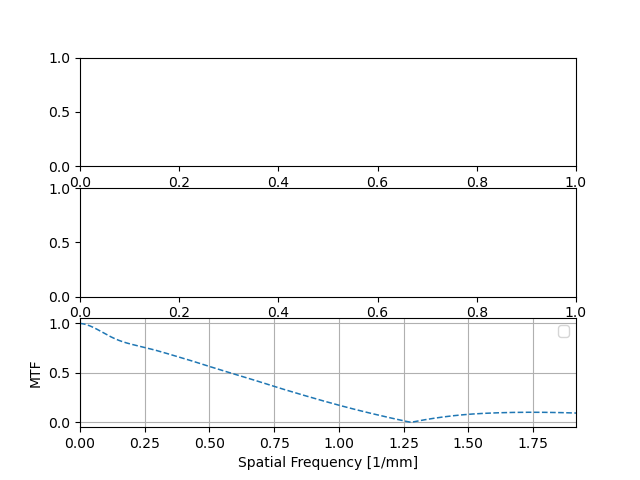

No handles with labels found to put in legend.


ratio is None number of photons 0.021328344994554917


In [5]:
s = fc.Spectrum()

contrasts = []
mtfs = []
label = []

fig, axs = plt.subplots(3, 1)

for phan in phantoms[:1]:
    phantom = dispatcher[phan]()
    for spectrum in sorted(spectra):
        for det in sorted(MV_detectors):
            
            s.load(spectrum.split('/')[-1].split('.')[0])
            kernel = fc.Kernel(s, det.split('/')[-1].split('.')[0])
            kernel.get_plot_mtf_real(axs[2])
            mtfs.append([kernel.freq,kernel.mtf])
            angles = np.linspace(0,np.pi*2,360)#480)        

            phantom.return_projs(kernel,s,angles,det_on=False)
            phantom.reconstruct('FDK')
            contrasts.append(phantom.analyse_515(phantom.img[5],axs))
            label.append([phan,spectrum,det])
            
            break
        break
    break

<IPython.core.display.Javascript object>


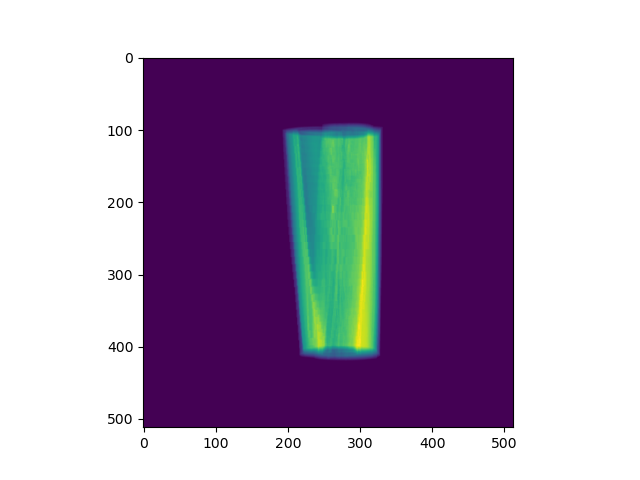

In [6]:
plt.figure()
plt.imshow(phantom.proj[0])
proj1 = phantom.proj[0]

<IPython.core.display.Javascript object>


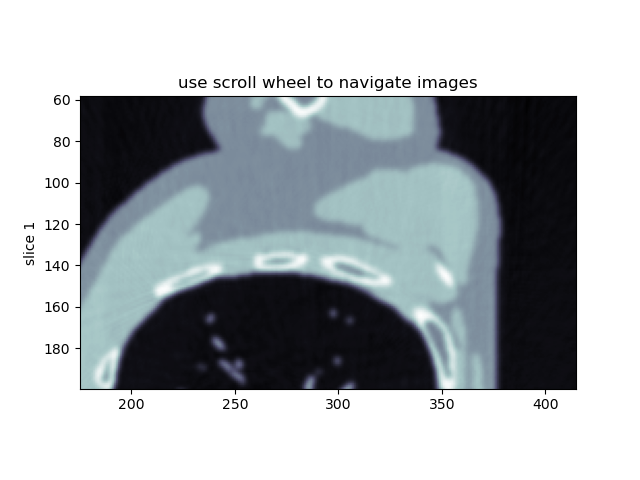

In [13]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind],cmap='bone')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

X = np.array(phantom.img.T)

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


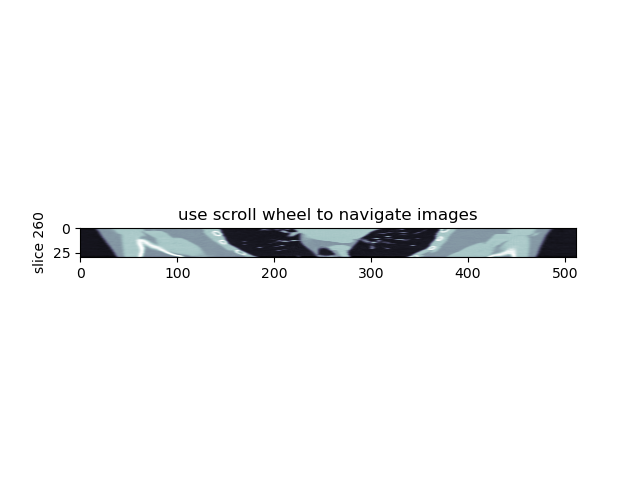

In [12]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind],cmap='bone')
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

X = np.array(phantom.img.transpose([0,2,1]))

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [19]:
np.save('contrasts',contrasts)
np.save('mtfs',mtfs)
np.save('labels',label)

/home/xcite/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


<IPython.core.display.Javascript object>


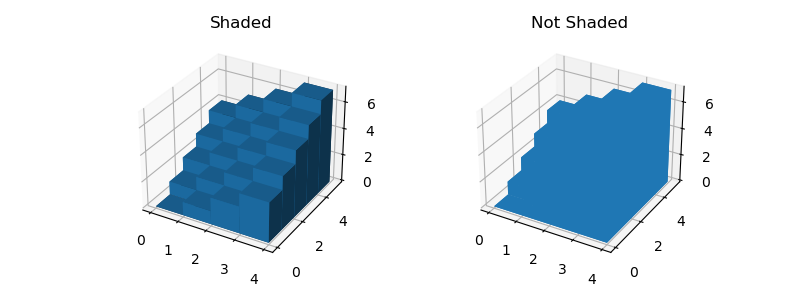

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

contrasts_i_want = [contrasts[ii][]]
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

plt.show()

In [69]:
from matplotlib import cm

<IPython.core.display.Javascript object>


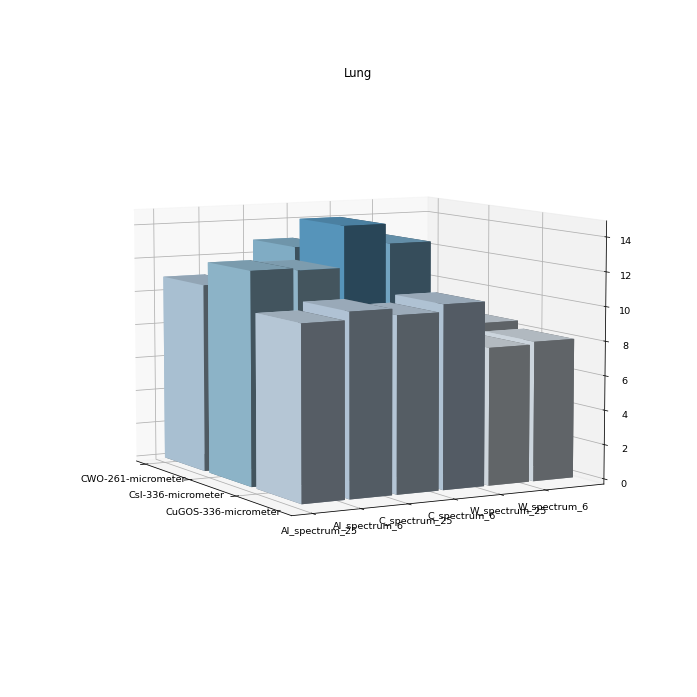

/home/xcite/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


<IPython.core.display.Javascript object>


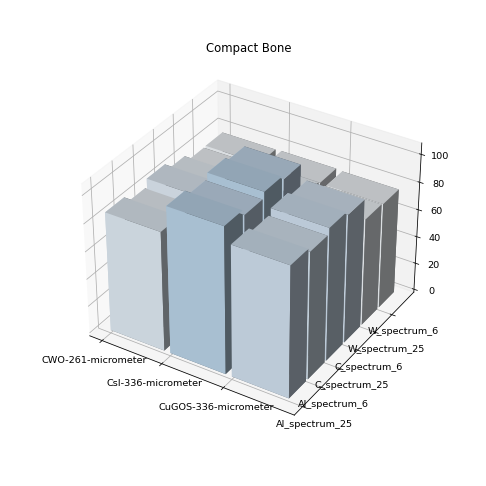

<IPython.core.display.Javascript object>


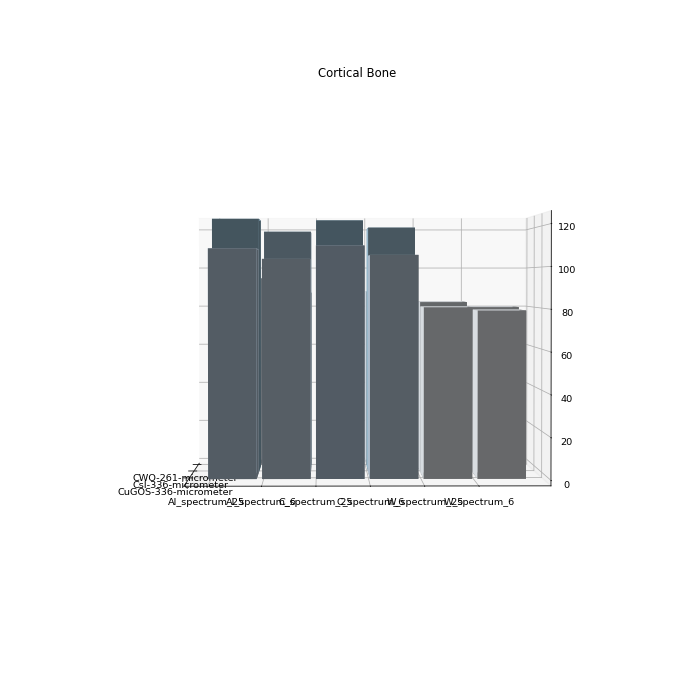

<IPython.core.display.Javascript object>


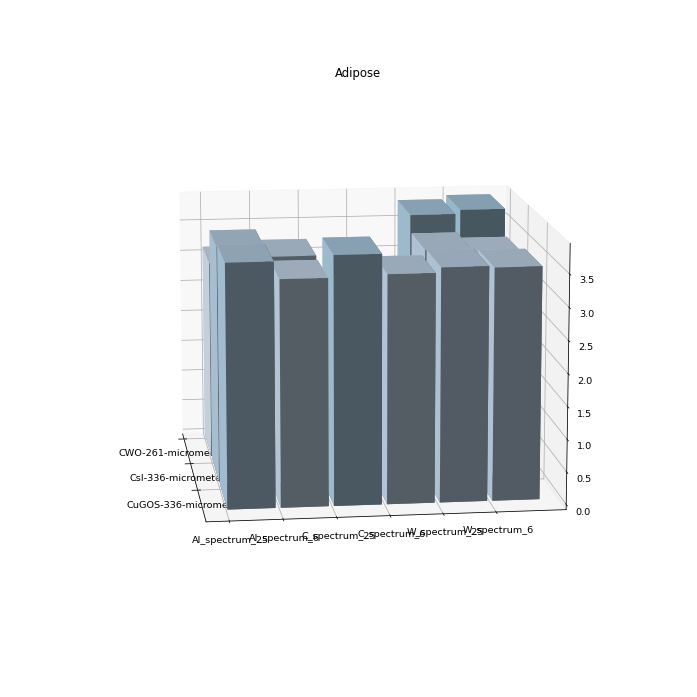

<IPython.core.display.Javascript object>


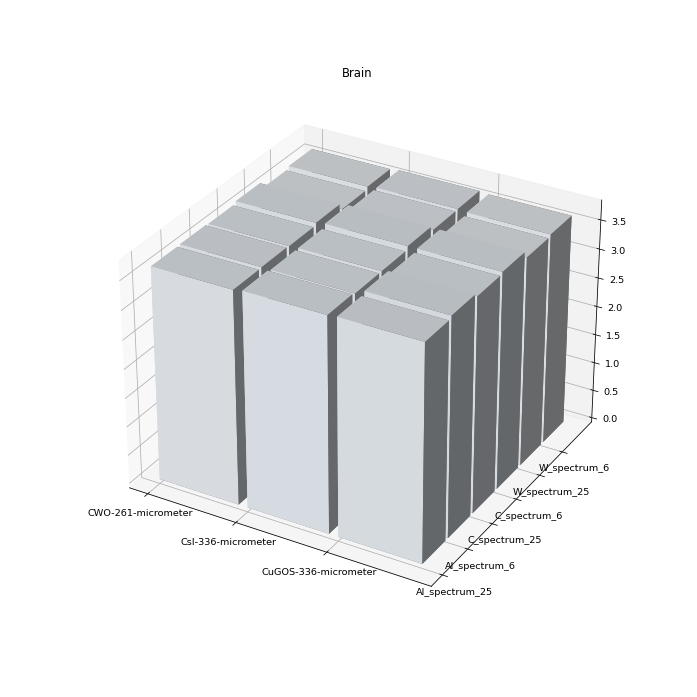

<IPython.core.display.Javascript object>


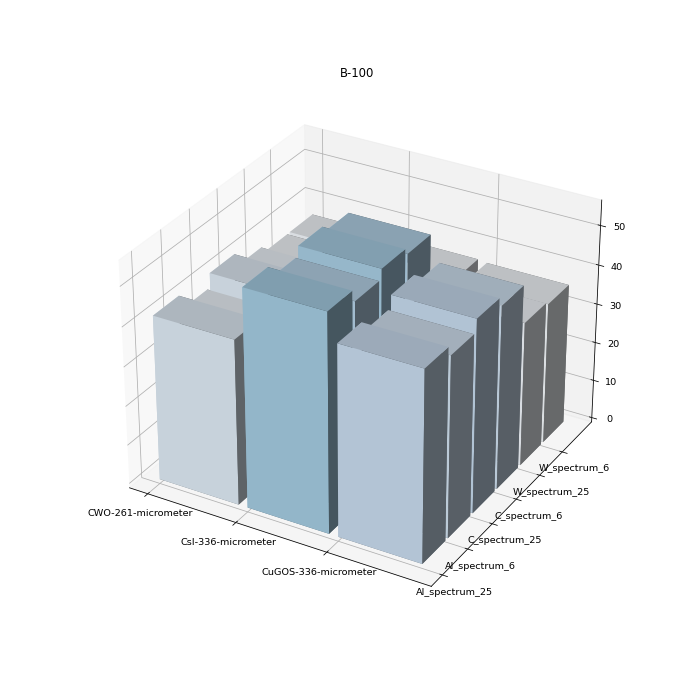

In [109]:
inds_i_want = [0,6,12,18,21,24]
shorts = ['Lung','Compact Bone','Cortical Bone','Adipose','Brain','B-100']

contrasts_only = [contrasts[ii][1] for ii in range(len(contrasts))]

contrast_ar = np.array(contrasts_only)[:,inds_i_want]

dets_i_want = [0,3,6]

contrasts_to_plot = contrast_ar[::3,0].reshape([3,6])

lx, ly = contrasts_to_plot.shape

_x = np.arange(lx)
_y = np.arange(ly)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
width = depth = 0.9

specs = [spectra[kk].split('/')[-1].split('.')[0] for kk in range(len(spectra))]
detz = [MV_detectors[kk].split('/')[-1].split('.')[0] for kk in range(len(MV_detectors))]

for jj in range(len(inds_i_want)):
    
    contrasts_to_plot = contrast_ar[::3,jj].reshape([3,6]).flatten()#.reshape([len(spectra),int(len(contrasts)/len(spectra))])

    cmap = cm.get_cmap('Blues') # Get desired colormap - you can change this!
    max_height = np.max(contrasts_to_plot)   # get range of colorbars so we can normalize
    min_height = np.min(contrasts_to_plot)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in contrasts_to_plot] 

    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.bar3d(x,y, bottom, width, depth, contrasts_to_plot,color=rgba, zsort='average', shade=True)
    ax1.set_title(shorts[jj])
    ax1.set_yticks(range(len(spectra)))
    ax1.set_yticklabels(sorted(specs))
    ax1.set_xticks(range(len(detz[::3])))
    ax1.set_xticklabels(sorted(detz)[::3])
    plt.tight_layout()
    
#     break

In [88]:
np.array(label)[:,1].reshape([len(spectra),int(len(contrasts)/len(spectra))])

array([['../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_25.txt'],
       ['../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al_spectrum_6.txt',
        '../fastcat/data/MV_spectra/Al

In [108]:
detz

['CuGOS-392-micrometer',
 'CWO-784-micrometer',
 'CuGOS-784-micrometer',
 'CsI-392-micrometer',
 'CuGOS-336-micrometer',
 'CWO-392-micrometer',
 'CsI-784-micrometer',
 'CWO-261-micrometer',
 'CsI-336-micrometer']

In [89]:
np.array(label)[:,2].reshape([len(spectra),int(len(contrasts)/len(spectra))])

array([['../fastcat/data/Detectors/CWO-261-micrometer',
        '../fastcat/data/Detectors/CWO-392-micrometer',
        '../fastcat/data/Detectors/CWO-784-micrometer',
        '../fastcat/data/Detectors/CsI-336-micrometer',
        '../fastcat/data/Detectors/CsI-392-micrometer',
        '../fastcat/data/Detectors/CsI-784-micrometer',
        '../fastcat/data/Detectors/CuGOS-336-micrometer',
        '../fastcat/data/Detectors/CuGOS-392-micrometer',
        '../fastcat/data/Detectors/CuGOS-784-micrometer'],
       ['../fastcat/data/Detectors/CWO-261-micrometer',
        '../fastcat/data/Detectors/CWO-392-micrometer',
        '../fastcat/data/Detectors/CWO-784-micrometer',
        '../fastcat/data/Detectors/CsI-336-micrometer',
        '../fastcat/data/Detectors/CsI-392-micrometer',
        '../fastcat/data/Detectors/CsI-784-micrometer',
        '../fastcat/data/Detectors/CuGOS-336-micrometer',
        '../fastcat/data/Detectors/CuGOS-392-micrometer',
        '../fastcat/data/Detectors/Cu

In [91]:
contrast_ar[:,0].reshape([len(spectra),int(len(contrasts)/len(spectra))]).flatten()

array([10.94017538, 10.91813642, 10.94120732, 12.33236147, 12.30379796,
       12.30942803, 10.00898376, 10.00442507,  9.98202601, 11.30305439,
       11.2847624 , 11.26505964, 12.20998428, 12.16116432, 12.19630993,
       10.48481183, 10.47977956, 10.45809289, 12.89002102, 12.90404621,
       12.90185399, 14.61528942, 14.6249419 , 14.67340515, 10.11429075,
       10.09519276, 10.09851538, 12.41890821, 12.42877168, 12.46004897,
       13.46521681, 13.49752204, 13.46466291, 10.55510461, 10.56961973,
       10.55533228,  6.9022765 ,  6.91422433,  6.90450925,  8.19008695,
        8.18565598,  8.19404018,  7.91018029,  7.93289181,  7.92613491,
        7.14180457,  7.1456152 ,  7.13077258,  8.48668059,  8.509874  ,
        8.47786037,  8.07174783,  8.08153531,  8.06178995])

<IPython.core.display.Javascript object>


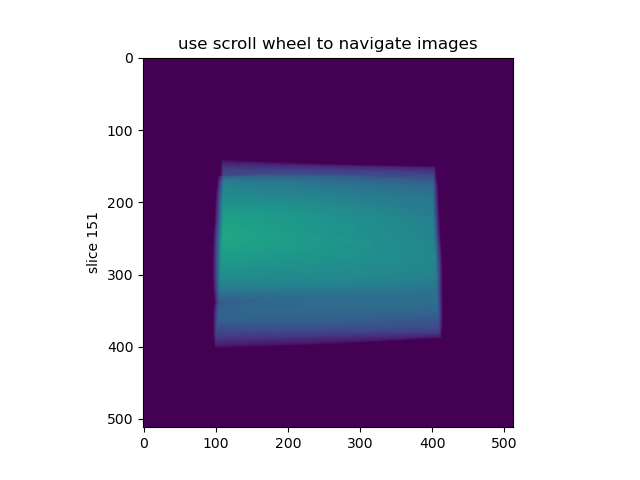

In [10]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        rows, cols, self.slices = X.shape
        self.ind = self.slices//2

        self.im = ax.imshow(self.X[:, :, self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind + 1) % self.slices
        else:
            self.ind = (self.ind - 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[:, :, self.ind])
        ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

fig, ax = plt.subplots(1, 1)

X = np.array(phantom.proj.T)

tracker = IndexTracker(ax, X)

fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()